In [69]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from torchvision.models import vit_b_16, ViT_B_16_Weights
import matplotlib.pyplot as plt

In [70]:
# Constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_SIZE = 224  # ViT expects 224x224 images
IMAGE_CHANNELS = 3

# Load and preprocess data
data = np.load('snipe_data_rgb_full_cropped.npz')['arr_0']
print(f"Data shape after loading: {data.shape}")

# filter out people with too few photos
# there are probably better ways of doing this, but this works
# allyn = 1, evelyn = 5, katie = 8, kiana = 9
# mike = 11, nathan = 13, reilly = 15, spencer = 16
num_classes = 8
label_names = ['Allyn','Evelyn','Katie','Kiana','Mike','Nathan','Reilly','Spencer']
data = data[np.isin(data[:, 0], (1, 5, 8, 9, 11, 13, 15, 16))]
label_map = {1:0, 5:1, 8:2, 9:3, 11:4, 13:5, 15:6, 16:7}
for i in range(data.shape[0]):
    data[i][0] = label_map[data[i][0]]
print(f"Data shape after filtering: {data.shape}")
print(f"Labels after filtering: {np.unique(data[:,0])}")

labels = data[:, 0].astype(np.int64)

# Calculate expected pixels per image
pixels_per_image = 3 * IMAGE_HEIGHT * IMAGE_WIDTH  # 147,456
print(f"Pixels per image: {pixels_per_image}")

# Calculate total features per sample
total_features_per_sample = data.shape[1] - 1  # Excluding the label
print(f"Total features per sample (excluding label): {total_features_per_sample}")

# Determine number of additional features
num_additional_features = total_features_per_sample - pixels_per_image
print(f"Number of additional features: {num_additional_features}")

if num_additional_features < 0:
    raise ValueError("Total features per sample is less than the expected number of pixels per image.")

# Adjust indexing based on where the image data is located
# Assuming additional features are before the image data
image_data = data[:, 1 + num_additional_features:].astype(np.uint8)

print("Image data shape:", image_data.shape)  # Should be (num_images, 3, 256, 192)
print("Data type:", image_data.dtype)  # Should be np.uint8 if it's raw pixel data in [0, 255]
print("Min pixel value:", image_data.min(), "Max pixel value:", image_data.max())  # Check for [0, 255] range



# (Optional) Extract additional features if needed
metadata = data[:, 1:1 + num_additional_features]
print(f"Additional features shape: {metadata.shape}")

# Reshape image data to (num_samples, 3, H, W)
# image_data = image_data.reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
# print(f"Image data shape after reshaping: {image_data.shape}")

# Proceed with data splitting
X_train, X_test, y_train, y_test = train_test_split(
    image_data, labels, test_size=0.2, random_state=42, stratify=labels
)

Data shape after loading: (4246, 196616)
Data shape after filtering: (2848, 196616)
Labels after filtering: [0 1 2 3 4 5 6 7]
Pixels per image: 196608
Total features per sample (excluding label): 196615
Number of additional features: 7
Image data shape: (2848, 196608)
Data type: uint8
Min pixel value: 0 Max pixel value: 255
Additional features shape: (2848, 7)


In [71]:
metadata_df = pd.DataFrame(data=metadata, columns=["sniper", "was-aware", "month", "day", "hour", "minute", "week_day"])

# get one-hot encoding of the sniper category
one_hot = pd.get_dummies(metadata_df['sniper'])
metadata_df = metadata_df.drop('sniper',axis = 1)
metadata_df = metadata_df.join(one_hot)
metadata_arr = metadata_df.to_numpy().astype('uint8')

# append metadata and image data together o they can easily be passed through fully connected layers
data = np.hstack((metadata_arr, image_data))
NUM_METADATA = metadata_arr.shape[1]
print(NUM_METADATA)

23


In [72]:
# Proceed with data splitting
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

In [73]:
class ImageDataset(Dataset):
    def __init__(self, features, targets, transform=None):
        self.features = features
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        data = self.features[index]
        metadata = data[0:NUM_METADATA]
        image = data[NUM_METADATA:]
        image = image.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS).astype(np.uint8)
        label = self.targets[index]
        
        if self.transform:
            image = self.transform(image)
        
        new_data = np.concatenate((metadata.flatten(), image.flatten()))
        return new_data, label


In [74]:

# Data transformations
transform_train = transforms.Compose([
    transforms.ToPILImage(),  # Convert from HWC to PIL image
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Converts to CHW format and scales to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [75]:
# Create Datasets and DataLoaders
train_dataset = ImageDataset(X_train, y_train, transform=transform_train)
test_dataset = ImageDataset(X_test, y_test, transform=transform_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

(150551,)


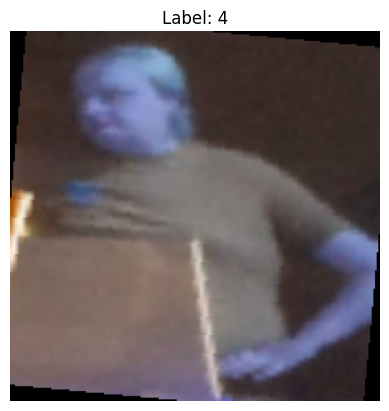

In [76]:
# Get a sample from the training dataset
sample_data, sample_label = train_dataset[1000]
print(sample_data.shape)
sample_metadata = sample_data[0:NUM_METADATA]
sample_image = sample_data[NUM_METADATA:]
sample_image = torch.from_numpy(sample_image.reshape(IMAGE_CHANNELS, 224, 224).astype(np.double))

# Undo the normalization for visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
sample_image = sample_image * std + mean  # Denormalize
sample_image = sample_image.clamp(0, 1)   # Ensure values are between 0 and 1

# Convert to numpy and transpose for plotting
sample_image_np = sample_image.numpy().transpose((1, 2, 0))  # CHW to HWC


plt.imshow(sample_image_np)
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()


In [77]:
# # Load pre-trained ViT model
# vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

# # Modify the classifier head
# num_ftrs = vit.heads.head.in_features
# vit.heads.head = nn.Linear(num_ftrs, 19)

# # Move the model to device
# vit = vit.to(device)

class CustomViTModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomViTModel, self).__init__()
        # Load the pre-trained ViT model
        self.vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

        num_ftrs = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Linear(num_ftrs, 16)
        
        # Define two fully connected layers for metadata
        self.fc1 = nn.Linear(NUM_METADATA, 32)
        self.fc2 = nn.Linear(32, 16)
        self.relu = nn.ReLU()

        # Define two fully connected layers for classification
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, num_classes)

    def forward(self, x):
        metadata = x[:, 0:NUM_METADATA]
        image = x[:, NUM_METADATA:]
        image = image.view(-1, IMAGE_CHANNELS, 224, 224)

        # Forward through ViT
        outputs = self.vit(image)
        # hidden_state = outputs.last_hidden_state[:, 0, :]  # [CLS] token representation

        # feed metadata through fc
        x = self.fc1(metadata)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)

        # combine together
        x = torch.cat((x,outputs), dim=1)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

In [78]:
# Define loss and optimizer
model = CustomViTModel(num_classes=19)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [79]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {running_loss/len(train_loader):.4f}, '
              f'Validation Accuracy: {val_accuracy:.2f}%')

        # Save the best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

    print(f'Best Validation Accuracy: {best_accuracy:.2f}%')

In [80]:
# Evaluation function with confusion matrix
def evaluate_model(model, test_loader, num_classes):
    model.eval()
    test_correct = 0
    test_total = 0

    # Set up confusion matrix
    predictions = np.zeros((num_classes, num_classes), dtype=np.float64)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model.forward(inputs)
            _, preds = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

            # Store data in confusion matrix
            for l, p in zip(labels, preds):
                predictions[l][p] += 1 

    # Normalize confusion matrix
    for label in range(num_classes):
        predictions[label] /= np.sum(predictions[label])

    test_accuracy = 100 * test_correct / test_total
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    
    return predictions


In [81]:
# Function to plot confusion matrix
def plot_confusion_matrix(arr, labels):
    fig, ax = plt.subplots()
    im = ax.imshow(arr)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    ax.set_title("Normalized Actual vs. Predicted Snipes")
    fig.colorbar(im, ax=ax)
    fig.tight_layout()
    plt.show()


In [82]:
# Step 0: Freeze all transformer layers to train fully connected layers
for param in model.parameters():
    param.requires_grad = True
for param in model.vit.parameters():
    param.requires_grad = False

# Set up the optimizer for training the fully connected layers only
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Train the model with the initial setup
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)
torch.save(model.state_dict(), "training_metadata_stage0.pth")

Epoch [1/5], Loss: 2.9411, Validation Accuracy: 7.72%
Epoch [2/5], Loss: 2.9299, Validation Accuracy: 15.96%
Epoch [3/5], Loss: 2.9031, Validation Accuracy: 15.79%
Epoch [4/5], Loss: 2.8729, Validation Accuracy: 15.61%
Epoch [5/5], Loss: 2.8609, Validation Accuracy: 15.79%
Best Validation Accuracy: 15.96%


Test Accuracy: 15.79%


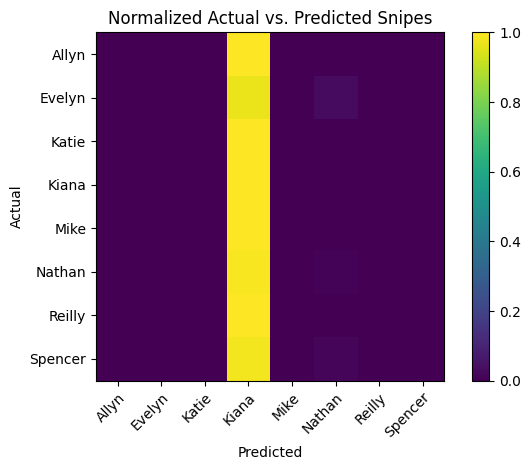

In [83]:
confusion_matrix = evaluate_model(model, test_loader, num_classes)
plot_confusion_matrix(confusion_matrix, label_names)

In [84]:
# Step 1: Freeze all transformer layers except the classifier head
for param in model.vit.parameters():
    param.requires_grad = False
for param in model.vit.heads.parameters():  # Assuming 'heads' is the classifier layer
    param.requires_grad = True

# Set up the optimizer for training the classifier head only
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Train the model with the initial setup
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)
torch.save(model.state_dict(), "training_metadata_stage1.pth")

Epoch [1/10], Loss: 2.8526, Validation Accuracy: 16.49%
Epoch [2/10], Loss: 2.8403, Validation Accuracy: 19.82%
Epoch [3/10], Loss: 2.8331, Validation Accuracy: 24.39%
Epoch [4/10], Loss: 2.8176, Validation Accuracy: 26.84%
Epoch [5/10], Loss: 2.7938, Validation Accuracy: 31.75%
Epoch [6/10], Loss: 2.7654, Validation Accuracy: 32.63%
Epoch [7/10], Loss: 2.7392, Validation Accuracy: 34.39%
Epoch [8/10], Loss: 2.7204, Validation Accuracy: 34.74%
Epoch [9/10], Loss: 2.7034, Validation Accuracy: 35.09%
Epoch [10/10], Loss: 2.6837, Validation Accuracy: 36.32%
Best Validation Accuracy: 36.32%


Test Accuracy: 36.32%


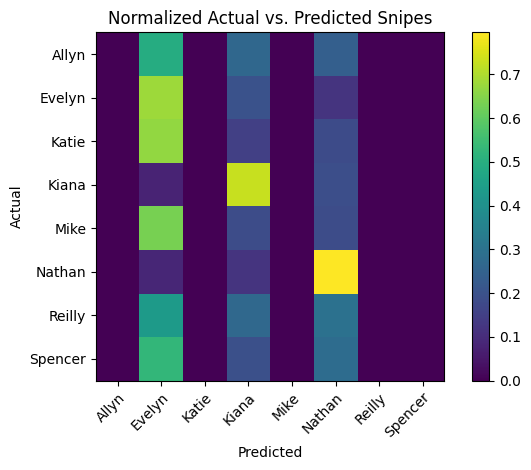

In [85]:
# Assuming your model and test_loader are defined, evaluate and plot
confusion_matrix = evaluate_model(model, test_loader, num_classes)
plot_confusion_matrix(confusion_matrix, label_names)

In [86]:
# Step 3: Unfreeze the last few transformer layers for fine-tuning
for param in model.vit.encoder.layers[-4:].parameters():  # Adjust based on ViT model structure
    param.requires_grad = True

# Adjust optimizer with a lower learning rate for fine-tuning
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# Continue training with fine-tuning on the last few transformer layers
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)
torch.save(model.state_dict(), "training_metadata_stage2.pth")


Epoch [1/5], Loss: 2.6641, Validation Accuracy: 40.00%
Epoch [2/5], Loss: 2.6235, Validation Accuracy: 41.75%
Epoch [3/5], Loss: 2.5974, Validation Accuracy: 43.33%
Epoch [4/5], Loss: 2.5770, Validation Accuracy: 43.68%
Epoch [5/5], Loss: 2.5644, Validation Accuracy: 41.75%
Best Validation Accuracy: 43.68%


Test Accuracy: 41.75%


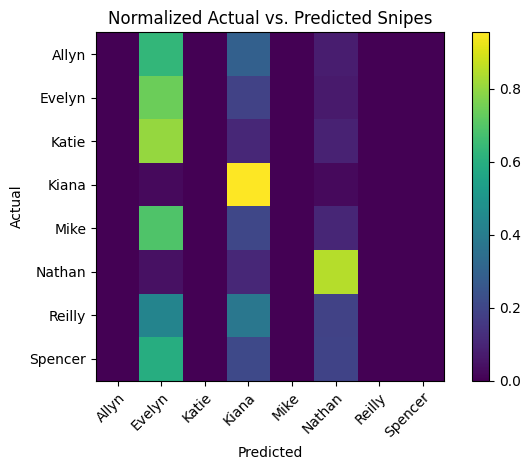

In [87]:
# Evaluate fine-tuning performance
confusion_matrix = evaluate_model(model, test_loader, num_classes)
plot_confusion_matrix(confusion_matrix, label_names)

In [88]:
# Step 5: Unfreeze all layers for complete fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Use an even lower learning rate for all layers
optimizer = optim.Adam(model.parameters(), lr=1e-6)

# Train with all layers unfreezed
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)
torch.save(model.state_dict(), "training_metadata_stage3.pth")


Epoch [1/5], Loss: 2.5579, Validation Accuracy: 44.91%
Epoch [2/5], Loss: 2.5512, Validation Accuracy: 45.09%


KeyboardInterrupt: 

Test Accuracy: 22.78%


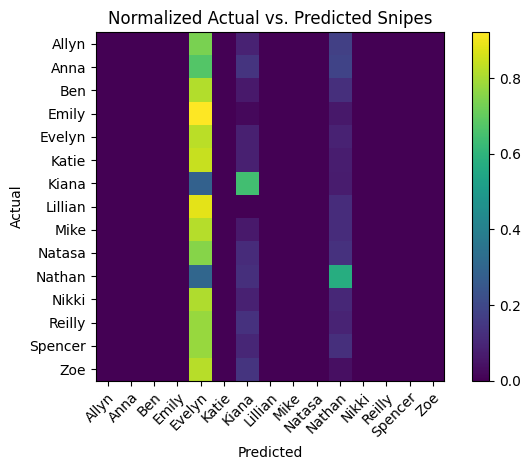

In [ ]:
# Evaluate fine-tuning performance
confusion_matrix = evaluate_model(model, test_loader, num_classes)
plot_confusion_matrix(confusion_matrix, label_names)